In [ ]:
#Check GPU availability

import torch

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU")

GPU is available


In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 34.5 MB/s eta 0:00:00


## 1. Load and Prepare the Data ##

In [ ]:
#from google.colab import files
#uploaded = files.upload()

Saving France.csv to France.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1.1 Select the country:

In [ ]:
# Define the country variable
country = 'Switzerland'  # Change this value to 'Germany', 'Spain', etc., as needed

file_path = f'/content/drive/My Drive/Prices/{country}.csv'


# Create the filename dynamically
filenameARIMA = f'results_ARIMA_GPU_{country}.pkl'
filenameNaive = f'results_Naive_GPU_{country}.pkl'

In [ ]:
import pandas as pd

# Assuming your data is in a CSV file
data = pd.read_csv(file_path)
data=data.iloc[-5000:]


# Define the training and test sets
train_data = data.iloc[:2000]
test_data = data.iloc[2000:]

print(train_data.tail())
print(train_data.shape, test_data.shape)

           Country ISO3 Code       Datetime (UTC)     Datetime (Local)  \
78067  Switzerland       CHE  2023-11-27 19:00:00  2023-11-27 20:00:00   
78068  Switzerland       CHE  2023-11-27 20:00:00  2023-11-27 21:00:00   
78069  Switzerland       CHE  2023-11-27 21:00:00  2023-11-27 22:00:00   
78070  Switzerland       CHE  2023-11-27 22:00:00  2023-11-27 23:00:00   
78071  Switzerland       CHE  2023-11-27 23:00:00  2023-11-28 00:00:00   

       Price (EUR/MWhe)  
78067            126.77  
78068            126.86  
78069            126.70  
78070            124.02  
78071            118.90  
(2000, 5) (3000, 5)


## 2. Stationarity Test ##

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries, significance_level=0.05):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

    if result[1] < significance_level:
        print(f'The series is stationary (p-value: {result[1]} < {significance_level})')
    else:
        print(f'The series is non-stationary (p-value: {result[1]} >= {significance_level})')

# Perform ADF test on the training data
adf_test(train_data['Price (EUR/MWhe)'])

ADF Statistic: -5.092140061927039
p-value: 1.4538242593848076e-05
Critical Values:
   1%: -3.4336687168076714
   5%: -2.863006019389988
   10%: -2.567550447906854
The series is stationary (p-value: 1.4538242593848076e-05 < 0.05)


## 3. Fit the ARIMA model on the first 2000 obs

In [ ]:
from pmdarima import auto_arima
# auto_arima chooses the best order for the ARIMA model automatically
model_arima=auto_arima(train_data['Price (EUR/MWhe)'], seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14806.713, Time=1.93 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15609.728, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15113.945, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15106.648, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15607.728, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14985.862, Time=1.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14805.058, Time=0.80 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15065.283, Time=0.57 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=15037.212, Time=0.48 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=14806.775, Time=3.17 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=15000.562, Time=1.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=14808.931, Time=2.76 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=14803.075, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=15063.284, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0

In [ ]:
forecast_steps=3000
forecast = model_arima.predict(n_periods=forecast_steps)

last_train_value = train_data['Price (EUR/MWhe)'].iloc[-1]
forecast_naive = np.full(3000, last_train_value)
print(forecast_naive)

[118.9 118.9 118.9 ... 118.9 118.9 118.9]


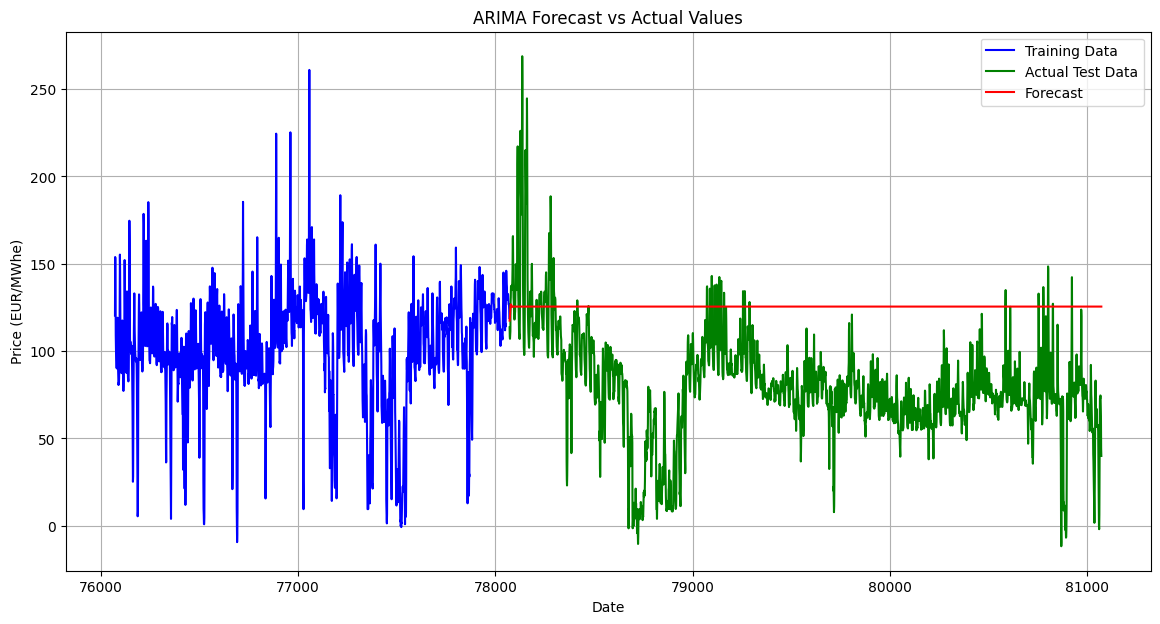

In [ ]:
# Plotting the results (Globally)
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['Price (EUR/MWhe)'], label='Training Data', color='blue')
plt.plot(test_data.index, test_data['Price (EUR/MWhe)'], label='Actual Test Data', color='green')
plt.plot(test_data.index, forecast, label='Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Price (EUR/MWhe)')
plt.title('ARIMA Forecast vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()

## 4. Create the pickle dicts

In [ ]:
#ARIMA

import numpy as np
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle

# Assuming `pipeline` is your Chronos pipeline and `df` is your DataFrame

# Function to calculate RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Initialize lists to store predictions, actual values, and window metrics
predictions = []
actuals = []

window_mae = []
window_rmse = []
window_mse = []

# Rolling window parameters
input_length = 96
prediction_length = 96

# Get the last 3000 rows of the DataFrame
df_last_3000 = test_data

# Initialize the iteration counter
nb_iter = 1

# Iterate over the last 3000 rows using a rolling window
for start_idx in range(len(df_last_3000) - input_length - prediction_length + 1):
    # Define the end index for the input and prediction window
    end_idx = start_idx + input_length
    pred_end_idx = end_idx + prediction_length

    # Extract the input sequence
    # input_sequence = df_last_3000.iloc[start_idx:end_idx]
    # Extract the actual prediction sequence
    actual_sequence = df_last_3000["Price (EUR/MWhe)"].to_numpy()[end_idx:pred_end_idx] #ok as of now


    # Store the median predictions (each sample over samples)
    predictionsARIMA=forecast.to_numpy()[end_idx:pred_end_idx]
    predictions.append(predictionsARIMA)
    actuals.append(actual_sequence)

    # Calculate metrics using median predictions for the current window
    window_mae.append(mean_absolute_error(actual_sequence, predictionsARIMA))
    window_rmse.append(root_mean_squared_error(actual_sequence, predictionsARIMA))
    window_mse.append(mean_squared_error(actual_sequence, predictionsARIMA))

    # Print the current iteration number with prefix 'nb'
    print(f"nb{nb_iter}")
    nb_iter=nb_iter+1

# Convert lists to numpy arrays for easier metric calculation
predictions = np.array(predictions)
actuals = np.array(actuals)

# Calculate global performance metrics as the mean of window metrics
global_mae = np.mean(window_mae)
global_rmse = np.mean(window_rmse)
global_mse = np.mean(window_mse)

# Store predictions and metrics in a dictionary
results = {
    "predictions": predictions,
    "actuals": actuals,
    "metrics": {
        "Global MAE": global_mae,
        "Global RMSE": global_rmse,
        "Global MSE": global_mse
    }
}

# Print the global metrics
print("Global MAE:", global_mae)
print("Global RMSE:", global_rmse)
print("Global MSE:", global_mse)

#To save: results

# Save dictionary as a pickle file
with open(filenameARIMA, 'wb') as pickle_file:
    pickle.dump(results, pickle_file)

# Download the file to your local machine
files.download(filenameARIMA)

nb1
nb2
nb3
nb4
nb5
nb6
nb7
nb8
nb9
nb10
nb11
nb12
nb13
nb14
nb15
nb16
nb17
nb18
nb19
nb20
nb21
nb22
nb23
nb24
nb25
nb26
nb27
nb28
nb29
nb30
nb31
nb32
nb33
nb34
nb35
nb36
nb37
nb38
nb39
nb40
nb41
nb42
nb43
nb44
nb45
nb46
nb47
nb48
nb49
nb50
nb51
nb52
nb53
nb54
nb55
nb56
nb57
nb58
nb59
nb60
nb61
nb62
nb63
nb64
nb65
nb66
nb67
nb68
nb69
nb70
nb71
nb72
nb73
nb74
nb75
nb76
nb77
nb78
nb79
nb80
nb81
nb82
nb83
nb84
nb85
nb86
nb87
nb88
nb89
nb90
nb91
nb92
nb93
nb94
nb95
nb96
nb97
nb98
nb99
nb100
nb101
nb102
nb103
nb104
nb105
nb106
nb107
nb108
nb109
nb110
nb111
nb112
nb113
nb114
nb115
nb116
nb117
nb118
nb119
nb120
nb121
nb122
nb123
nb124
nb125
nb126
nb127
nb128
nb129
nb130
nb131
nb132
nb133
nb134
nb135
nb136
nb137
nb138
nb139
nb140
nb141
nb142
nb143
nb144
nb145
nb146
nb147
nb148
nb149
nb150
nb151
nb152
nb153
nb154
nb155
nb156
nb157
nb158
nb159
nb160
nb161
nb162
nb163
nb164
nb165
nb166
nb167
nb168
nb169
nb170
nb171
nb172
nb173
nb174
nb175
nb176
nb177
nb178
nb179
nb180
nb181
nb182
nb183
nb184
nb18

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#NAIVE

import numpy as np
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle

# Assuming `pipeline` is your Chronos pipeline and `df` is your DataFrame

# Function to calculate RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Initialize lists to store predictions, actual values, and window metrics
predictions = []
actuals = []

window_mae = []
window_rmse = []
window_mse = []

# Rolling window parameters
input_length = 96
prediction_length = 96

# Get the last 3000 rows of the DataFrame
df_last_3000 = test_data

# Initialize the iteration counter
nb_iter = 1

# Iterate over the last 3000 rows using a rolling window
for start_idx in range(len(df_last_3000) - input_length - prediction_length + 1):
    # Define the end index for the input and prediction window
    end_idx = start_idx + input_length
    pred_end_idx = end_idx + prediction_length

    # Extract the input sequence
    # input_sequence = df_last_3000.iloc[start_idx:end_idx]
    # Extract the actual prediction sequence
    actual_sequence = df_last_3000["Price (EUR/MWhe)"].to_numpy()[end_idx:pred_end_idx] #ok as of now


    # Store the median predictions (each sample over samples)
    predictionsNaive=forecast_naive[end_idx:pred_end_idx]
    predictions.append(predictionsNaive)
    actuals.append(actual_sequence)

    # Calculate metrics using median predictions for the current window
    window_mae.append(mean_absolute_error(actual_sequence, predictionsNaive))
    window_rmse.append(root_mean_squared_error(actual_sequence, predictionsNaive))
    window_mse.append(mean_squared_error(actual_sequence, predictionsNaive))

    # Print the current iteration number with prefix 'nb'
    print(f"nb{nb_iter}")
    nb_iter=nb_iter+1

# Convert lists to numpy arrays for easier metric calculation
predictions = np.array(predictions)
actuals = np.array(actuals)

# Calculate global performance metrics as the mean of window metrics
global_mae = np.mean(window_mae)
global_rmse = np.mean(window_rmse)
global_mse = np.mean(window_mse)

# Store predictions and metrics in a dictionary
results = {
    "predictions": predictions,
    "actuals": actuals,
    "metrics": {
        "Global MAE": global_mae,
        "Global RMSE": global_rmse,
        "Global MSE": global_mse
    }
}

# Print the global metrics
print("Global MAE:", global_mae)
print("Global RMSE:", global_rmse)
print("Global MSE:", global_mse)

#To save: results

# Save dictionary as a pickle file
with open(filenameNaive, 'wb') as pickle_file:
    pickle.dump(results, pickle_file)

# Download the file to your local machine
files.download(filenameNaive)

nb1
nb2
nb3
nb4
nb5
nb6
nb7
nb8
nb9
nb10
nb11
nb12
nb13
nb14
nb15
nb16
nb17
nb18
nb19
nb20
nb21
nb22
nb23
nb24
nb25
nb26
nb27
nb28
nb29
nb30
nb31
nb32
nb33
nb34
nb35
nb36
nb37
nb38
nb39
nb40
nb41
nb42
nb43
nb44
nb45
nb46
nb47
nb48
nb49
nb50
nb51
nb52
nb53
nb54
nb55
nb56
nb57
nb58
nb59
nb60
nb61
nb62
nb63
nb64
nb65
nb66
nb67
nb68
nb69
nb70
nb71
nb72
nb73
nb74
nb75
nb76
nb77
nb78
nb79
nb80
nb81
nb82
nb83
nb84
nb85
nb86
nb87
nb88
nb89
nb90
nb91
nb92
nb93
nb94
nb95
nb96
nb97
nb98
nb99
nb100
nb101
nb102
nb103
nb104
nb105
nb106
nb107
nb108
nb109
nb110
nb111
nb112
nb113
nb114
nb115
nb116
nb117
nb118
nb119
nb120
nb121
nb122
nb123
nb124
nb125
nb126
nb127
nb128
nb129
nb130
nb131
nb132
nb133
nb134
nb135
nb136
nb137
nb138
nb139
nb140
nb141
nb142
nb143
nb144
nb145
nb146
nb147
nb148
nb149
nb150
nb151
nb152
nb153
nb154
nb155
nb156
nb157
nb158
nb159
nb160
nb161
nb162
nb163
nb164
nb165
nb166
nb167
nb168
nb169
nb170
nb171
nb172
nb173
nb174
nb175
nb176
nb177
nb178
nb179
nb180
nb181
nb182
nb183
nb184
nb18

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>